*   שם הפרויקט: זיהוי טקסט מתמונה
*   שם התלמיד: אורי צמח
*   dataset: https://fki.tic.heia-fr.ch/databases/iam-handwriting-database





video link for the application demonstration: https://drive.google.com/file/d/1oQI-MbSljMbwdLPfWPnpdWwYPVyCD-ra/view?usp=sharing

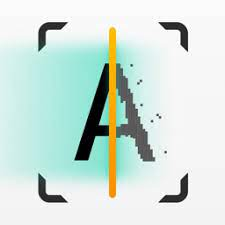

# Imports and Drive

In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np 
from tensorflow.keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle
from itertools import groupby

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Constants

In [3]:
vocab = [' ','!','"','#','&',"'",'(',')','*','+',',','-','.','/','0','1','2','3','4','5','6','7','8','9',':',';','?','A',
 'B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i',
 'j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

max_len = 21
batch_size = 64
height = 32 
width = 128
epochs = 140
learning_rate = 0.001

# Data Loading, Visualisation and Preparation

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Project/data.csv')
df.head()

,path,label
0,/content/drive/MyDrive/Project/dataset/a02/a02...,personal
1,/content/drive/MyDrive/Project/dataset/a02/a02...,mission
2,/content/drive/MyDrive/Project/dataset/a02/a02...,Minister
3,/content/drive/MyDrive/Project/dataset/a02/a02...,was
4,/content/drive/MyDrive/Project/dataset/a02/a02...,Prime


In [ ]:
datagen=ImageDataGenerator(rescale=1/255.,
                           validation_split=0.1,
                           rotation_range=15,
                           brightness_range=(0.5, 1.5))

In [ ]:
train, test = train_test_split(df, test_size=0.1, shuffle=True)


train_generator = datagen.flow_from_dataframe(
                        dataframe=train,
                        x_col="path",
                        y_col="label",
                        batch_size=batch_size,
                        class_mode="raw",
                        target_size=(height, width),
                        color_mode='grayscale',
                        subset='training'
                        )

val_generator = datagen.flow_from_dataframe(
                        dataframe=train,
                        x_col="path",
                        y_col="label",
                        batch_size=batch_size,
                        class_mode="raw",
                        target_size=(height, width),
                        color_mode='grayscale',
                        subset='validation'
                        )

test_generator = datagen.flow_from_dataframe(
                        dataframe=test,
                        x_col="path",
                        y_col="label",
                        batch_size=batch_size,
                        class_mode="raw",
                        color_mode='grayscale',
                        target_size=(height, width),
                        )

Found 810 validated image filenames.
Found 90 validated image filenames.
Found 100 validated image filenames.


In [ ]:
def wrap_generator(generator):
  """
    This function is an auxiliary function for the generator which encodes
    the y labels from strings to a numpy array.
  """

  for x_batch, y_batch in generator:
    res = None
    for i in range(len(y_batch)):
      
      #replace characters with digits.
      encode = np.array([vocab.index(l) for l in y_batch[i]])
      
      #pad the result to obtain a uniform size.
      y_batch[i] = np.pad(encode, (0, max_len - len(y_batch[i])), 'constant', constant_values=len(vocab)).reshape(1, -1)
      
      if res is None:
        res = y_batch[i]
      else:
        res = np.concatenate((res, y_batch[i]))

    yield x_batch, res

Displaying samples from the dataset

In [ ]:
x_batch, y_batch = next(train_generator)

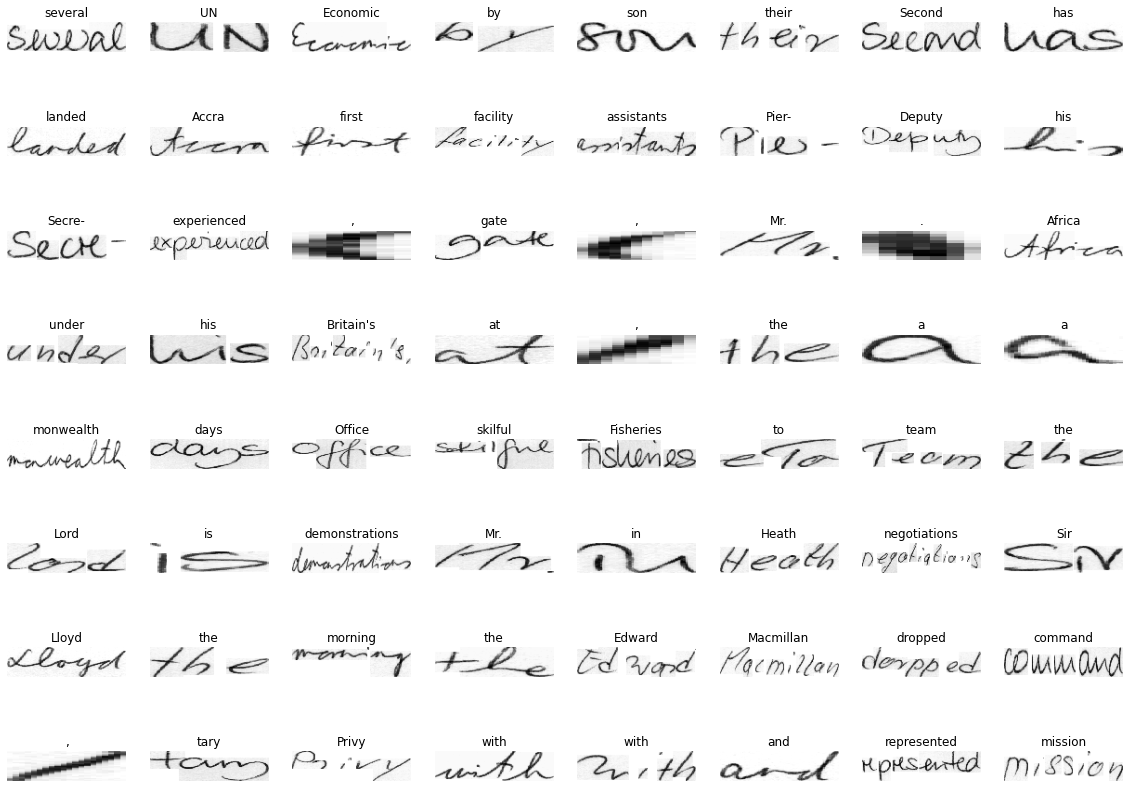

In [ ]:
fig = plt.figure(figsize=(20, 15))
  
# setting values to rows and column variables
rows = 8
columns = 8

#plotting the graphs
for i in range(len(x_batch)):
  fig.add_subplot(rows, columns, i+1)

  plt.imshow(x_batch[i], cmap='gray')
  plt.axis('off')
  plt.title(y_batch[i])

# Model Preparing and Training

Building the model based on ResNet Architecture

In [5]:
def activation_layer(layer, activation):
    """ 
      This function provides easy access to activation layers for the model.
      mainly useful for testing.
    """
    if activation == 'relu':
        layer = layers.ReLU()(layer)
    elif activation == 'leaky_relu':
        layer = layers.LeakyReLU()(layer)

    return layer

In [6]:
def residual_block(x, filter_num, strides, activation, kernel_size=(3,3), skip_conv=True, 
    padding='same', dropout=0.2):
  
    """
      This function defines a residual block like the one introduced in
      the ResNet architecture (with some modifications). 
    """
  
    # Create skip connection tensor
    x_skip = x

    # Perform 1-st convolution
    x = layers.Conv2D(filter_num, kernel_size, padding = padding, strides = strides, activation=activation)(x)
    x = layers.BatchNormalization()(x)

    # Perform 2-nd convolution
    x = layers.Conv2D(filter_num, kernel_size, padding = padding)(x)

    # Perform 3-rd convolution if skip_conv is True, matching the number of filters and the shape of the skip connection tensor
    if skip_conv:
        x_skip = layers.Conv2D(filter_num, (1,1), padding = padding, strides = strides)(x_skip)

    # Add x and skip connection and apply activation function
    x = layers.Add()([x, x_skip])     
    x = activation_layer(x, activation=activation)
    x = layers.BatchNormalization()(x)

    # Apply dropout
    if dropout:
        x = layers.Dropout(dropout)(x)

    return x

In [7]:
def build_model(input_dim, output_dim, activation='leaky_relu', dropout=0.2):

  """
  This function builds the model architecture similar to the
  ResNet architecture with added modifications and LSTM integration.
  """

  inputs = layers.Input(shape=input_dim, name="input")
                
  x1 = residual_block(inputs, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)							
                
  x2 = residual_block(x1, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)							
  x3 = residual_block(x2, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)							
  x4 = residual_block(x3, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)							
                
  x5 = residual_block(x4, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)							
  x6 = residual_block(x5, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)							
  x7 = residual_block(x6, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)							
                
  x8 = residual_block(x7, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)							
  x9 = residual_block(x8, 64, activation=activation, skip_conv=True, strides=1, dropout=dropout)							
                
  x10 = residual_block(x9, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)							
  x11 = residual_block(x10, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)							
  x12 = residual_block(x11, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)							
                
  squeezed = layers.Reshape((x12.shape[-3] * x12.shape[-2], x12.shape[-1]))(x12)							
                
  blstm1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(squeezed)							
  blstm1 = layers.Dropout(dropout)(blstm1)							
  blstm2 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(blstm1)							
  blstm2 = layers.Dropout(dropout)(blstm2)							
                
  output = layers.Dense(output_dim + 1, activation='softmax', name="output")(blstm2)							
                
  model = Model(inputs=inputs, outputs=output)							

  return model							

In [8]:
model = build_model(
    input_dim = (height, width, 1),
    output_dim = len(vocab),
    activation='relu'
)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 32, 128, 16)  160         ['input[0][0]']                  
                                                                                                  
 batch_normalization_48 (BatchN  (None, 32, 128, 16)  64         ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                            

## CTC loss

This class is responsible for supplying the correct format for the CTC loss function implemented by keras. 

In [9]:
class CTCloss(tf.keras.losses.Loss):
  """ CTCLoss objec for training the model"""
  def __init__(self, name='CTCloss'):
      super(CTCloss, self).__init__()
      self.name = name
      self.loss_fn = tf.keras.backend.ctc_batch_cost

  def __call__(self, y_true, y_pred, sample_weight=None):
      """ Compute the training batch CTC loss value"""

      batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
      input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
      label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

      input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
      label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

      loss = self.loss_fn(y_true, y_pred, input_length, label_length)

      return loss

## Custom Metric

This metric is a custom metric I have found which calculates character 
error rate (CER) and a word error rate (WER)

In [10]:
class CWERMetric(tf.keras.metrics.Metric):

    """
      This class implements a Custom metric commonly used in OCR.
      It tracks the WER (Word Error Rate) and the CER (Character Error Rate) - 
      the Levenshtein distance between the true and predicted labels.
    """

    def __init__(self, padding_token, name='CWER', **kwargs):
        # Initialize the base Metric class
        super(CWERMetric, self).__init__(name=name, **kwargs)
        
        # Initialize variables to keep track of the cumulative character/word error rates and counter
        self.cer_accumulator = tf.Variable(0.0, name="cer_accumulator", dtype=tf.float32)
        self.wer_accumulator = tf.Variable(0.0, name="wer_accumulator", dtype=tf.float32)
        self.batch_counter = tf.Variable(0, name="batch_counter", dtype=tf.int32)
        
        # Store the padding token as an attribute
        self.padding_token = padding_token

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Updates the state variables of the metric.
        Args:
            y_true: A tensor of true labels with shape (batch_size, sequence_length).
            y_pred: A tensor of predicted labels with shape (batch_size, sequence_length, num_classes).
            sample_weight: (Optional) a tensor of weights with shape (batch_size, sequence_length).
        """
        # Get the input shape and length
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0], dtype='int32') * tf.cast(input_shape[1], 'int32')
        
        # Decode the predicted labels using greedy decoding
        decode_predicted, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)
        
        # Convert the dense decode tensor to a sparse tensor
        predicted_labels_sparse = tf.keras.backend.ctc_label_dense_to_sparse(decode_predicted[0], input_length)
        
        # Convert the dense true labels tensor to a sparse tensor and cast to int64
        true_labels_sparse = tf.cast(tf.keras.backend.ctc_label_dense_to_sparse(y_true, input_length), "int64")
        
        # remove the padding elements in the predicted labels tensor
        predicted_labels_sparse = tf.sparse.retain(predicted_labels_sparse, tf.not_equal(predicted_labels_sparse.values, -1))
        
        # remove the padding elements in the true labels tensor
        true_labels_sparse = tf.sparse.retain(true_labels_sparse, tf.not_equal(true_labels_sparse.values, self.padding_token))

        # Calculate the normalized edit distance between the predicted labels and true labels tensors
        distance = tf.edit_distance(predicted_labels_sparse, true_labels_sparse, normalize=True)

        # Add the sum of the distance tensor to the cer_accumulator variable
        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        
        # Increment the batch_counter by the batch size
        self.batch_counter.assign_add(len(y_true))

        # Calculate the number of wrong words in batch and add to wer_accumulator variable
        self.wer_accumulator.assign_add(tf.reduce_sum(tf.cast(tf.not_equal(distance, 0), tf.float32)))

    def result(self):
        """Computes and returns the metric result.
        Returns:
            A dictionary containing the CER and WER.
        """
        return {
                "CER": tf.math.divide_no_nan(self.cer_accumulator, tf.cast(self.batch_counter, tf.float32)),
                "WER": tf.math.divide_no_nan(self.wer_accumulator, tf.cast(self.batch_counter, tf.float32))
        }

## Training the Model

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), 
    loss=CTCloss(),
    metrics=[CWERMetric(padding_token=len(vocab))]
)

Callbacks

In [ ]:
earlystopper = EarlyStopping(monitor='val_CER', patience=12, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Project/model/run1.ckpt', monitor='val_CER',
                             verbose=1, save_best_only=True, mode='min', save_weights_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_CER', factor=0.5, min_delta=1e-10, patience=6, verbose=1, mode='auto')

In [ ]:
steps_train = train_generator.n // batch_size
steps_val = val_generator.n // batch_size

history = model.fit(wrap_generator(train_generator),
          batch_size=batch_size,
          steps_per_epoch=steps_train,
          validation_data=wrap_generator(val_generator),
          validation_steps=steps_val,
          epochs=epochs,
          callbacks=[earlystopper, checkpoint, reduceLROnPlat]
)

save the history object

In [ ]:
with open('/content/drive/MyDrive/Project/trainHistory/trainHistory4.txt', 'wb') as f:
    pickle.dump(history.history, f)

# Performance Evaluation

Restore best weights

In [12]:
model.load_weights('/content/drive/MyDrive/Project/model/model17.ckpt')

In [ ]:
steps_test = test_generator.n // batch_size
model.evaluate(test_generator, steps=steps_test) # returns a list: [loss, CER, WER]

the result of the evaluation is:


*   accuracy: 79.77%
*   test CER: 0.0944
*   test loss: 1.6224



Plot the learning curves

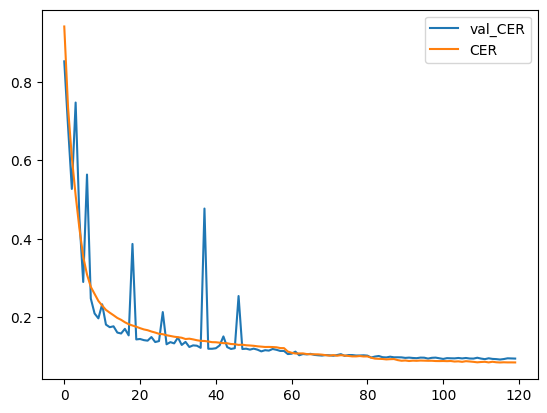

In [ ]:
with open('/content/drive/MyDrive/Project/trainHistory/trainHistory17.txt', "rb") as file_pi:
    history = pickle.load(file_pi)

plt.plot(history['val_CER'], label='val_CER')
plt.plot(history['CER'], label='CER')
plt.legend()
plt.show()

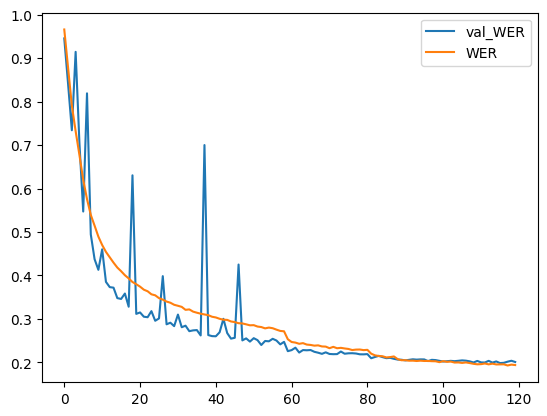

In [ ]:
plt.plot(history['val_WER'], label='val_WER')
plt.plot(history['WER'], label='WER')
plt.legend()
plt.show()

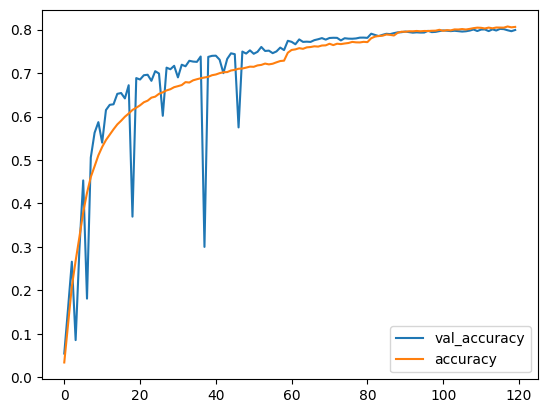

In [ ]:
plt.plot([1 - WER for WER in history['val_WER']], label='val_accuracy')
plt.plot([1 - WER for WER in history['WER']], label='accuracy')
plt.legend()
plt.show()

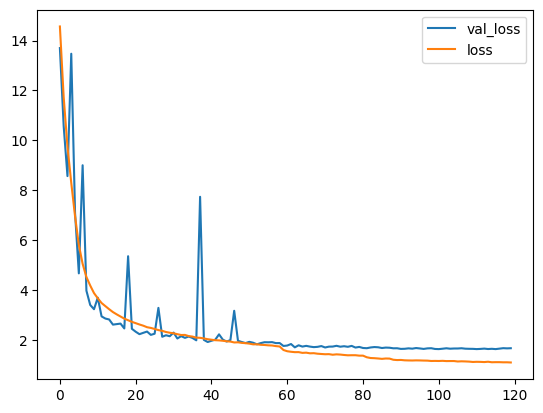

In [ ]:
plt.plot(history['val_loss'], label='val_loss')
plt.plot(history['loss'], label='loss')
plt.legend()
plt.show()

## Predicting Samples Outside of the Dataset

In [13]:
def ctc_decoder(predictions):

    """
      A simple ctc decoder for the encoded label result.
    """

    # use argmax to find the index of the highest probability
    argmax_preds = np.argmax(predictions, axis=-1)

    # use groupby to find continuous same indexes
    grouped_preds = [[k for k, _ in groupby(preds)] for preds in argmax_preds]

    # convert indexes to chars
    texts = ["".join([vocab[k] for k in group if k < len(vocab)]) for group in grouped_preds]

    return texts

In [14]:
def predict(img, verbos=0):

  """
    This function predicts a single sample from a black and white image
    and returns the predicted text.
  """

  image = img / 255.
  
  image = cv2.resize(image, (width, height))

  image = np.expand_dims(image, axis=0).astype(np.float32) # model expect batches

  preds = model.predict(image, verbose=verbos)
  text = ctc_decoder(preds)[0]
  return text

# Visualizing Tests Predictions

In [ ]:
x_batch, y_batch = next(test_generator)

2/2 [==============================] - 0s 20ms/step
the format is (true label, predicted label)


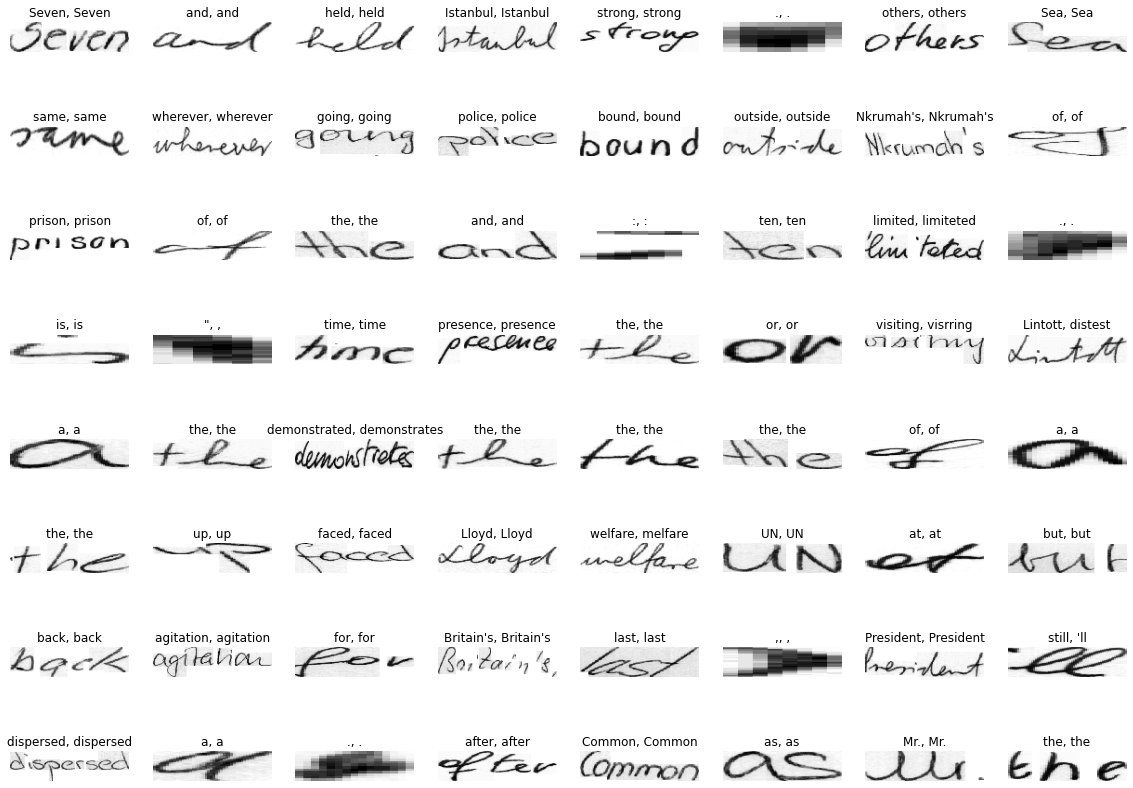

In [ ]:
fig = plt.figure(figsize=(20, 15))
  
# setting values to rows and column variables
rows = 8
columns = 8

preds = model.predict(x_batch)
labels = ctc_decoder(preds)

print("the format is (true label, predicted label)")

for i in range(len(x_batch)):
  fig.add_subplot(rows, columns, i+1)

  plt.imshow(x_batch[i], cmap='gray')
  plt.axis('off')
  plt.title(f'{y_batch[i]}, {labels[i]}')

# Document Prediction

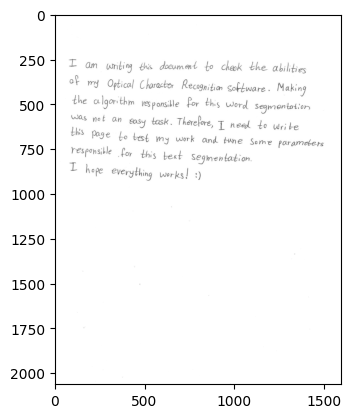

In [15]:
"""read the document and convert to grayscale."""

img = cv2.imread('/content/drive/MyDrive/Project/test.jpg')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img1, cmap='gray') 

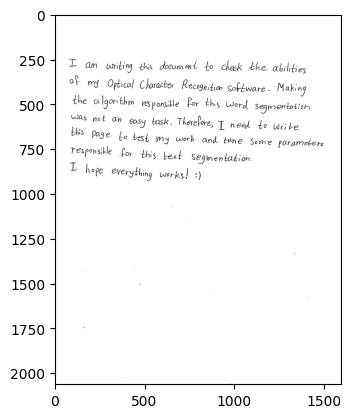

In [16]:
""" 
  This code section applies preprocessing functions to the document
  to improve prediction results.
"""

# threshold the image.
threshed = cv2.adaptiveThreshold(img1, 255,
                cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 30);    
    
# Clean all noises.
denoised = cv2.fastNlMeansDenoising(threshed, dst=None, h=10)
plt.imshow(denoised, cmap='gray')

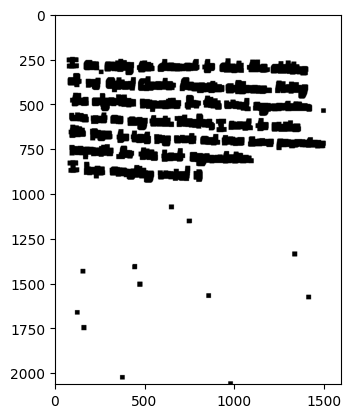

In [17]:
"""
  This code section dialtes the document to group words together
  to find the contours of words.
"""

# Negative the image and dilate.
imagem = cv2.bitwise_not(denoised)
kernel = np.ones((3, 3), np.uint8)
dilate = cv2.dilate(imagem, kernel, iterations=12) 

# Negative it again to original color
final = cv2.bitwise_not(dilate)

plt.imshow(final, cmap='gray')

In [18]:
""" find the countors of the word """

contours, hierarchy = cv2.findContours(final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

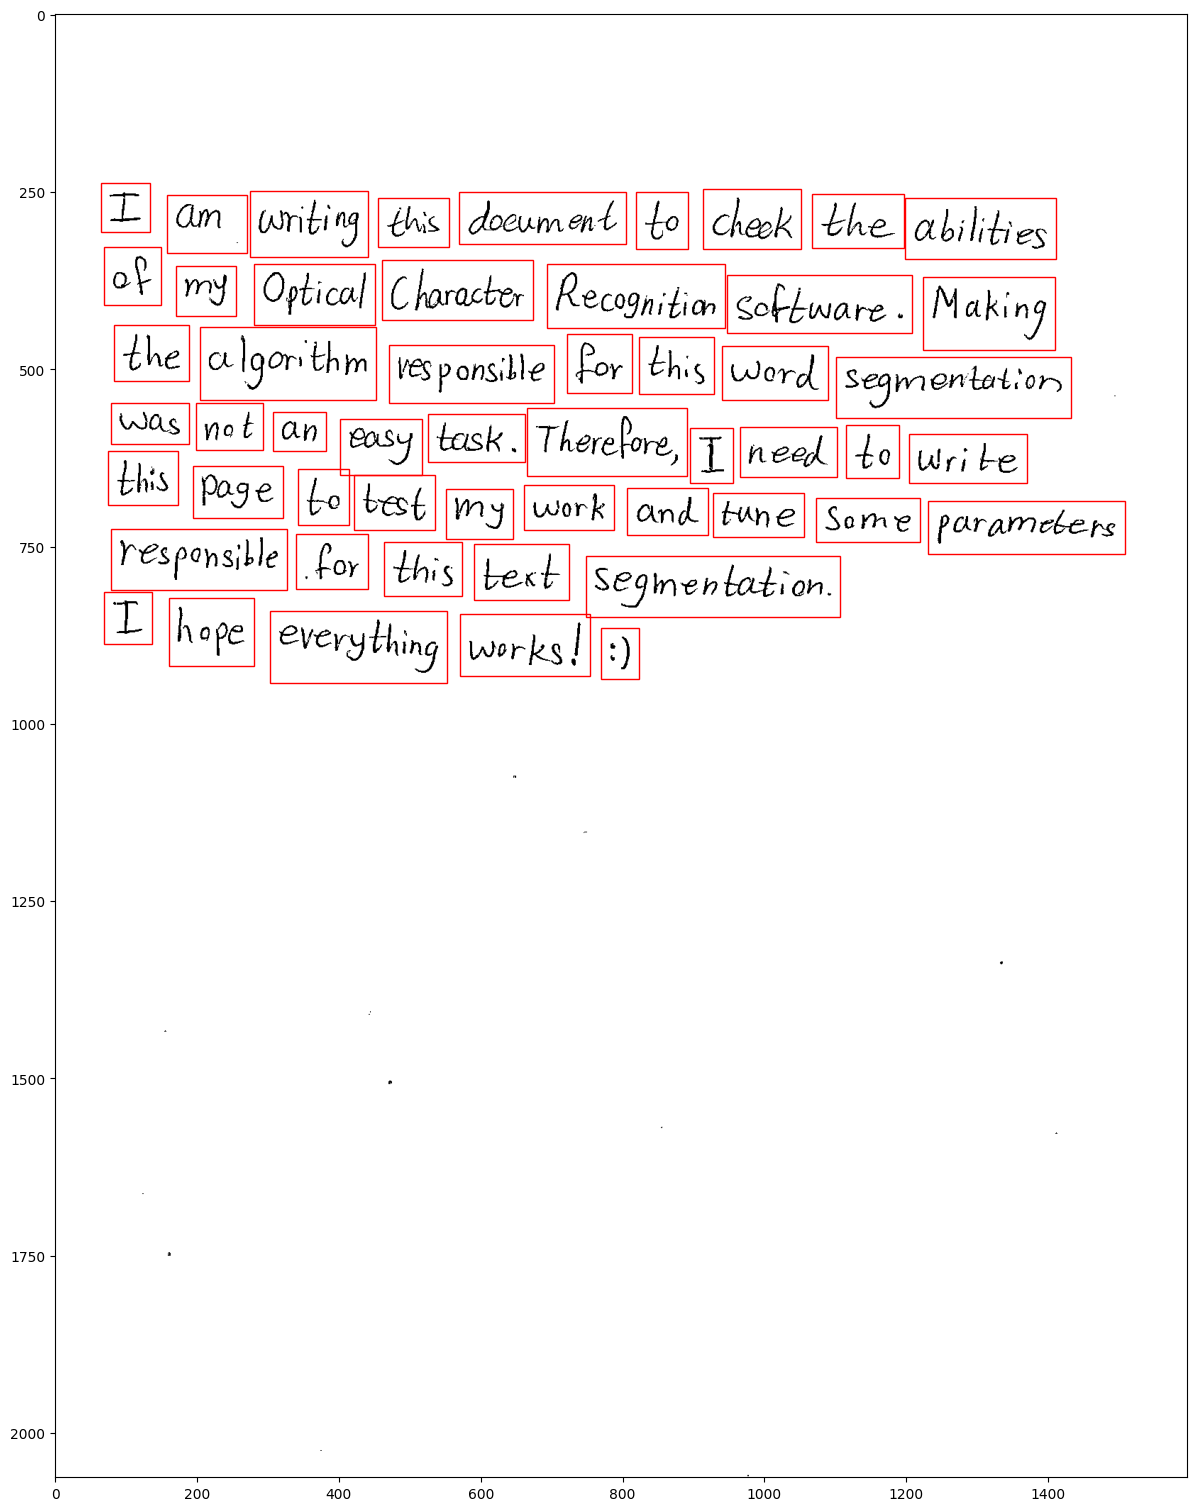

In [19]:
"""
  this code section visualizes the countors generated by OpenCV
  and removes the noise countors by thresholding.
"""

import matplotlib.patches as patches

rects = []

# Create figure and axes
fig, ax = plt.subplots(figsize=(19,19))

# Display the image
ax.imshow(denoised, cmap='gray')

for cont in contours:
  (x, y, w, h) = cv2.boundingRect(cont)

  # Clean all small contours out.
  thresh = 1000
  if h*w < thresh or w >= img1.shape[1] or h >= img1.shape[0]:
    continue
  
  rects.append((x, y, w, h))
  # Create a Rectangle patch
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)
  word = img1[y:y+h, x:x+w]

plt.show()

In [ ]:
def sort_rectangles(rectangles):

    """
      This function sorts the bounding boxes of words according to
      the word's x, y position.
    """

    # the tolerance to how much can the user write in non straight lines.
    tolerance = 1.1

    # Group rectangles into lines
    lines = []
    for rect in rectangles:
        # Find the line that this rectangle belongs to
        for line in lines:
            if abs(rect[1] - line[0][1]) <= line[0][3] * tolerance:
                line.append(rect)
                break
        else: # No existing line found, create a new one
            lines.append([rect])
    
    # Sort the lines by y-coordinate
    lines.sort(key=lambda line: line[0][1])

    # Sort the rectangles within each line by x-coordinate
    for line in lines:
        line.sort(key=lambda rect: rect[0])
    
    return lines

In [ ]:
text = sort_rectangles(rects)

In [ ]:
""" this code section predicts the words according to the sorted order in text """

for line in text:
  s = ""
  for word in line:
    (x, y, w, h) = word
    cut = denoised[y:y+h, x:x+w]
    s += predict(cut) + " "
  print(s)

I am. writing doerument to check the 
of my Optical this Character Recgmition software- abilities Making 
the algoritim responsible for this word segmentation 
was not a easy task- Therefores I ned to write 
tis page to test work 
responsible for this my text Segmentation and tune same parancters 
I. hope everything works' is 


# Deploying the Project on Android

## Create the tflite Model

This code section is responsible for converting the model to the tensorflow lite format required for mobile use.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

In [ ]:
with open('/content/drive/MyDrive/Project/LiteModel/model.tflite', 'wb') as f:
  f.write(tflite_model)

## Test the Model

 We will test the model with the word "This"

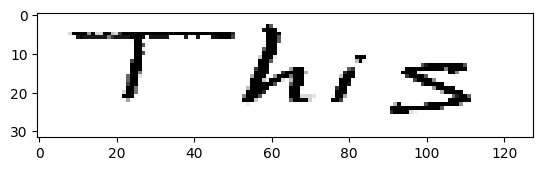

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Project/word.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (width, height)) / 255.

plt.imshow(img, cmap='gray')

img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=-1)

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Project/LiteModel/model_new.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model with sample input data.
input_data = img.astype('float32')
interpreter.set_tensor(input_details[0]["index"], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])

print(output_data) # softmax output

[[[1.46563969e-10 1.60823022e-09 6.63780156e-07 ... 2.65870995e-07
   1.33847582e-08 5.28612929e-07]
  [6.35368591e-10 5.08451503e-10 1.72499490e-08 ... 9.12420504e-08
   4.31553127e-11 6.88816217e-05]
  [1.15936601e-10 1.13558837e-12 4.02544421e-11 ... 1.36664891e-09
   4.25306627e-13 8.06401134e-01]
  ...
  [5.22101850e-12 1.51199418e-11 9.09439368e-09 ... 5.64288086e-07
   3.27638077e-07 4.46817512e-03]
  [1.27192564e-07 2.81649948e-09 6.27229099e-07 ... 5.78355639e-06
   3.82923048e-07 1.95794374e-01]
  [7.27098231e-05 9.56258646e-07 4.39138530e-05 ... 2.06122501e-03
   1.40142565e-05 3.83520573e-01]]]


In [ ]:
ctc_decoder(output_data)

['This']